Class Weight+Model

1. Import necessary Libraries

We have not used Feature Engineering and Standardization/Normalization


In [3]:
#For computational and random seed purpose
import numpy as np
np.random.seed(42)
#to read csv file
import pandas as pd
#To split into train and cv data
from sklearn.model_selection import train_test_split
#To compute AUROC
from sklearn.metrics import auc,roc_auc_score
#for AUROC graph
import matplotlib.pyplot as plt
#for oversampling technique
from imblearn.over_sampling import SMOTE # (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
#Data is imbalanced, we need calibrated model
from sklearn.calibration import CalibratedClassifierCV
#for hyperparameter tuning and Cross-validation fold
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold
#to ignore the error message
import warnings
warnings.filterwarnings("ignore")
#for heatmap and other plotting technique
import seaborn as sns
#to strandize the real value data
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#To create Knn model on datasets
from sklearn.neighbors import KNeighborsClassifier
#for roc_curve
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

import eli5
from eli5.sklearn import PermutationImportance
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from scipy.stats import kurtosis
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
#from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler

In [11]:
#locate parent directory
data_dir = "./"

#Read the training data
df_train = pd.read_csv('train.csv')
print(df_train)


      id  target      0      1      2  ...    295    296    297    298    299
0      0     1.0 -0.098  2.165  0.681  ... -2.097  1.051 -0.414  1.038 -1.065
1      1     0.0  1.081 -0.973 -0.383  ... -1.624 -0.458 -1.099 -0.936  0.973
2      2     1.0 -0.523 -0.089 -0.348  ... -1.165 -1.544  0.004  0.800 -1.211
3      3     1.0  0.067 -0.021  0.392  ...  0.467 -0.562 -0.254 -0.533  0.238
4      4     1.0  2.347 -0.831  0.511  ...  1.378  1.246  1.478  0.428  0.253
..   ...     ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
245  245     0.0 -1.199  0.466 -0.908  ... -0.243  0.525  0.281 -0.255 -1.136
246  246     0.0  0.237  0.233 -0.380  ...  1.004 -0.979  0.007  0.112 -0.558
247  247     0.0  1.411 -1.465  0.119  ... -0.727  0.461  0.760  0.168 -0.719
248  248     1.0  0.620  1.040  0.184  ...  0.478 -0.910 -0.805  2.029 -0.423
249  249     0.0  0.489  0.403  0.139  ...  0.812  0.269 -1.454 -0.625  1.474

[250 rows x 302 columns]


In [12]:
#Read test data
df_test = pd.read_csv('test.csv')
df_test

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,...,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,...,-1.791,0.122,-0.669,-1.558,-0.244,2.583,-0.829,0.133,-2.746,0.341,-1.145,0.492,0.437,-0.628,0.271,2.639,0.481,-0.687,1.017,1.648,-1.272,-0.797,-0.870,-1.582,-1.987,-0.052,-0.194,0.539,-1.788,-0.433,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,0.167,-0.132,0.459,-0.341,0.014,0.184,-0.460,-0.991,-1.039,0.992,1.036,1.552,-0.830,1.374,-0.914,0.427,0.027,0.327,1.117,0.871,-2.556,-0.036,-0.081,0.744,-1.191,-1.784,0.239,0.500,0.437,0.746,...,-1.167,1.009,-0.180,-0.683,-1.383,1.020,0.268,-1.558,0.620,-0.489,-2.090,-0.977,1.672,-0.655,-0.801,-1.846,0.761,-0.846,0.181,0.962,-0.611,1.450,0.021,0.320,-0.951,-2.662,0.761,-0.665,-0.619,-0.645,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,0.567,0.356,-0.060,0.767,-0.196,0.359,0.080,-0.956,0.857,-0.655,-0.090,-0.008,-0.596,-0.413,-1.030,0.173,-0.969,0.998,0.079,0.790,-0.776,-0.374,-1.995,0.572,0.542,0.547,0.307,-0.074,1.703,-0.003,...,-1.029,-0.340,0.052,2.122,-0.136,-1.799,1.450,1.866,-0.273,-0.237,-0.207,-0.196,-1.106,-1.560,-0.934,2.167,0.323,0.583,1.480,-0.685,-0.473,-1.066,-0.271,0.506,-0.753,1.048,-0.450,-0.300,-1.221,0.235,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,-0.930,-0.098,0.896,0.293,-0.259,0.030,-0.661,0.921,0.006,-0.631,1.284,-1.167,-0.744,-2.184,2.146,1.130,0.017,1.421,-0.590,1.938,-0.194,0.794,0.579,0.521,0.635,-0.023,-0.892,-0.363,-0.360,0.405,...,-0.486,-0.068,-0.534,-1.322,0.500,0.263,-0.745,0.578,-0.064,0.738,-0.280,0.745,-0.588,-0.429,-0.588,0.154,-1.187,1.681,-0.832,-0.437,-0.038,-1.096,-0.156,3.565,-0.428,-0.384,1.243,-0.966,1.525,0.458,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19745,19995,1.069,0.517,-0.690,0.241,0.913,-0.859,0.093,-0.359,-0.047,0.713,2.191,0.774,-0.110,-0.721,0.375,0.577,-0.192,-1.345,0.042,0.786,0.774,2.458,0.634,-0.664,-0.486,0.136,-0.506,0.509,-2.206,-1.035,-0.828,0.335,-0.963,0.946,1.728,0.256,-0.938,0.041,-0.112,...,-0.079,-0.853,0.708,0.301,0.636,-0.688,0.220,-1.192,1.257,-0.664,-1.258,-1.199,-0.145,0.581,-0.613,2.775,-0.254,-0.027,-1.088,-0.461,-0.356,-0.622,-0.228,-0.490,1.011,0.655,1.088,-0.796,-0.261,-1.219,0.495,1.021,0.126,-0.353,-0.092,0.996,-0.381,-0.748,1.567,1.165
19746,19996,-0.529,0.438,0.672,1.436,-0.720,0.698,-0.350,2.150,-1.241,-0.167,-0.188,0.541,-0.392,1.727,-0.965,0.550,-2.164,-0.523,-0.144,-0.931,0.703,0.464,-0.919,-0.867,-1.345,-0.634,0.121,0.877,-1.665,-0.086,-0.703,-0.874,0.676,1.671,0.356,0.365,-

In [13]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [14]:
X_train = (df_train.drop(['id','target'],axis = 1))
X_test = (df_test.drop(['id'],axis = 1))

y_train = df_train['target']

#n_fold = 20
#folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
#repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)



In [15]:
X_train.shape

(250, 300)

In [16]:
X_test.shape

(19750, 300)

**I will do hyper tuning**

In [104]:
def hyperparameter_model(models, params):
  '''
  Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by␣
  ,→CalibratedClassifier
  Parameters:
  models: Instance of the model 
  params: list of parameters with value fr tuning (dict)
  Return:
  grid_clf: return gridsearch model
  '''
  # Perform KCrossValidation with stratified target
  str_cv = StratifiedKFold(n_splits=11, random_state=42,shuffle=True)
  # Perform Hyperparamter using GridSearchCV
  grid_clf = GridSearchCV(models, params, cv=str_cv, return_train_score=True,scoring='roc_auc')
  # Fit the train model to evaluate score
  grid_clf.fit(X_train, y_train)
  return grid_clf

In [105]:
#kNN (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.→neighbors.KNeighborsClassifier.html)
# List of params
# List of params
params = {'n_neighbors':np.arange(3,51,2).tolist(), 'algorithm': ['kd_tree','brute']}

# Instance of knn model
knn_model = KNeighborsClassifier()
# Call hyperparameter for find the best params as possible
knn_clf = hyperparameter_model(knn_model, params)


In [108]:
print(knn_clf.best_params_)

{'algorithm': 'kd_tree', 'n_neighbors': 45}


In [109]:
from sklearn.utils import class_weight
knn_model = KNeighborsClassifier(**knn_clf.best_params_,weights='uniform')
knn_model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=45)

In [110]:
y_pred = knn_model.predict(X_train)
print(y_pred)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [111]:
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

0.5555555555555556


In [112]:
y_predict = knn_model.predict_proba(X_test)[:,1]

In [113]:
y_pred_lr_test = pd.DataFrame({"ID": df_test['id'],"Target": y_predict})


y_pred_lr_test.to_csv('submission_knn_file.csv', index=False)  
y_pred_lr_test.head(20)

,ID,Target
0,250,0.666667
1,251,0.622222
2,252,0.600000
3,253,0.644444
4,254,0.644444
5,255,0.600000
6,256,0.622222
7,257,0.644444
8,258,0.644444
9,259,0.555556


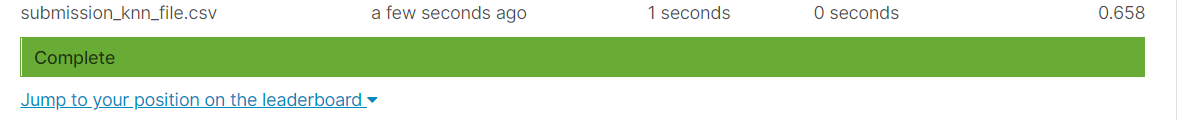

test_auc = 0.658

**Logistic Regresstion Applied**

In [25]:
#ref= https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

params = {'penalty':['l1','l2','elasticnet'],'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag']}

#the instance  of Logistic Regression

log_model = LogisticRegression(random_state=42)

#Call Hyper-parameter function to get best hyperparameter tuning

log_clf = hyperparameter_model(log_model,params)



In [26]:
print(log_clf.best_params_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [27]:
from sklearn import linear_model

model = LogisticRegression(class_weight = 'balanced',penalty='l1', C=0.1, solver='liblinear')

model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [28]:
y_pred = model.predict(X_train)
print(y_pred)

[1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]


In [29]:
train_auc_lr = roc_auc_score(y_train,y_pred)
print(train_auc_lr)

0.8951388888888888


In [30]:
y_pred_lr_test = model.predict_proba(X_test)[:,1]
print(y_pred_lr_test)

[0.66542599 0.49363699 0.54808538 ... 0.34306623 0.79406723 0.22330863]


In [31]:
y_pred_lr_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_lr_test})


y_pred_lr_test.to_csv('submission_logs_fie.csv', index=False)  
y_pred_lr_test.head(20)

,ID,Target
0,250,0.665426
1,251,0.493637
2,252,0.548085
3,253,0.758678
4,254,0.401662
5,255,0.313830
6,256,0.339976
7,257,0.211075
8,258,0.673940
9,259,0.214554


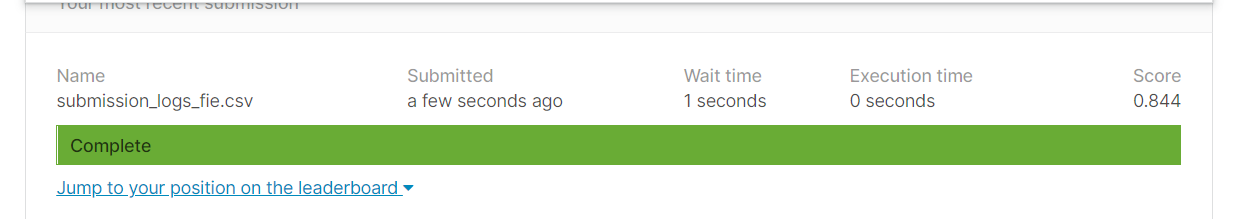

logistic_test_auc = 0.844

**Support Vector Machine**

In [32]:
from sklearn.svm import SVC

In [33]:
#ref = https://scikit-learn.org/stable/modules/svm.html

params = {'C':[10**i for i in range(-4,5)],'kernel':['linear','poly','sigmoid','rdf']}

#The instance of SVC

svc_model = SVC(class_weight='balanced',random_state=42)
#call the hyper-parameter function to get best parameters

svc_clf = hyperparameter_model(svc_model,params)

In [34]:
print(svc_clf.best_params_)

{'C': 0.0001, 'kernel': 'sigmoid'}


In [35]:
svc_clf = SVC(C = 0.0001, kernel = 'sigmoid',probability=True)
svc_clf.fit(X_train,y_train)

SVC(C=0.0001, kernel='sigmoid', probability=True)

In [36]:
y_pred = svc_clf.predict(X_train)
train_svm_auc = roc_auc_score(y_train,y_pred)
print(train_svm_auc)

0.5


In [37]:
y_pred_svc_test = svc_clf.predict_proba(X_test)[:,1]


In [38]:
y_pred_svc_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_svc_test})


y_pred_svc_test.to_csv('submission_svm_file.csv', index=False)  
y_pred_svc_test.head(10)

,ID,Target
0,250,0.588435
1,251,0.809681
2,252,0.429262
3,253,0.868921
4,254,0.468427
5,255,0.514445
6,256,0.267929
7,257,0.790950
8,258,0.414834
9,259,0.634586


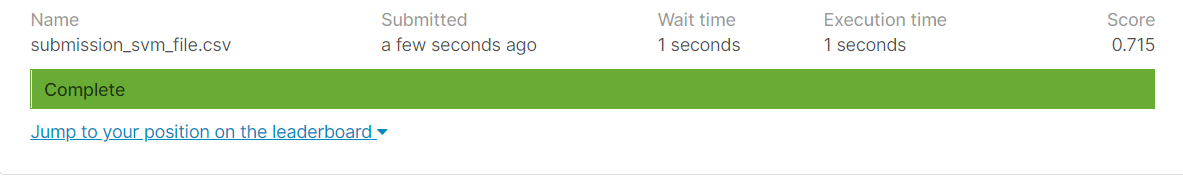

Test_SVM_auc = 0.72

**Ensemble Model : Random Forest**

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {'n_estimators': [10,20,30,40,50,60,100,200,300,400,500],'max_depth':[2,3,5,7,9]}

#The instance of model

rdf_model = RandomForestClassifier(random_state=42)

# Call the hyperparameter function  to get best parameter
rdf_clf = hyperparameter_model(rdf_model,params)


In [42]:
print(rdf_clf.best_params_)

{'max_depth': 2, 'n_estimators': 400}


In [43]:
rdf_clf = RandomForestClassifier(**rdf_clf.best_params_,bootstrap=True)
rdf_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=2, n_estimators=400)

In [44]:
y_pred = rdf_clf.predict(X_train)
train_rdf_auc = roc_auc_score(y_train,y_pred)
print(train_rdf_auc)

0.5166666666666666


In [45]:
y_pred_rdf_test = rdf_clf.predict_proba(X_test)[:,1]

In [46]:
y_pred_rdf_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_rdf_test})


y_pred_rdf_test.to_csv('submission_rdf_file.csv', index=False)  
y_pred_rdf_test.head(20)

,ID,Target
0,250,0.647066
1,251,0.641644
2,252,0.610497
3,253,0.686939
4,254,0.646141
5,255,0.605542
6,256,0.585545
7,257,0.616321
8,258,0.665471
9,259,0.598260


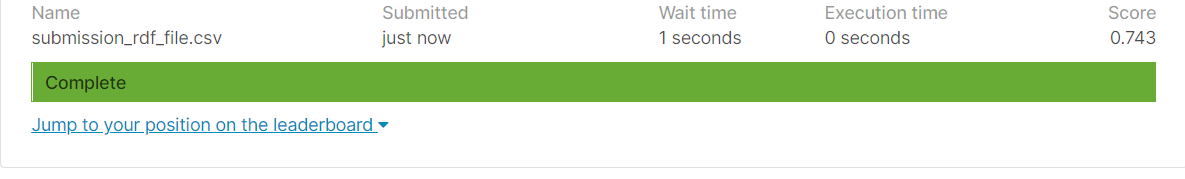

Test_rdf_auc : 0.74

**Decision Tree Classifier**

In [79]:
from sklearn.tree import DecisionTreeClassifier

In [98]:
#ref =https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

params =  {'max_depth':[3,5,7,9]}

#The instance of Decision Tree Classifier

tree_model = DecisionTreeClassifier(random_state=42)

#Call Hyperparameter function to get best parameter

tree_clf = hyperparameter_model(tree_model,params)

In [99]:
print(tree_clf.best_params_)

{'max_depth': 3}


In [100]:
tree_clf = DecisionTreeClassifier(**tree_clf.best_params_,class_weight='balanced')
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3)

In [101]:
y_pred = tree_clf.predict(X_train)
train_tree_auc = roc_auc_score(y_train,y_pred)
print(train_tree_auc)

0.7937500000000001


In [102]:
y_pred_tree_test = tree_clf.predict_proba(X_test)[:,1]


In [103]:
y_pred_tree_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_tree_test})


y_pred_tree_test.to_csv('submission_tree_file.csv', index=False)  
y_pred_tree_test.head(20)

,ID,Target
0,250,0.387560
1,251,0.830769
2,252,0.195143
3,253,0.830769
4,254,0.830769
5,255,0.195143
6,256,0.830769
7,257,0.830769
8,258,0.387560
9,259,0.195143


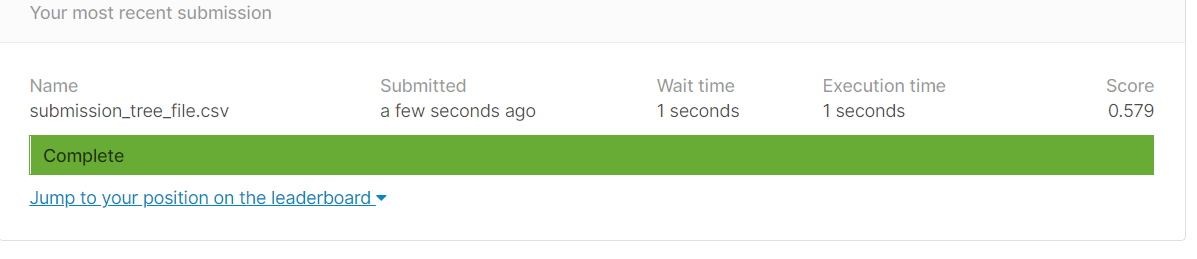

test_auc = 0.614

**XGBoost Classifier**

In [54]:
from xgboost import XGBClassifier

In [71]:
from scipy.sparse.construct import random
#list of hyper-parameter

params = {'max_depth':[2,3,5,7,9],'n_estimators':[10,20,30,40,50,100,200,400,500]}

# The instance of XGBClassifier

xg_model = XGBClassifier(random_state=42)
# call hyparameter function to get best parameter

xg_clf = hyperparameter_model(xg_model,params)

In [72]:
print(xg_clf.best_params_)

{'max_depth': 2, 'n_estimators': 500}


In [73]:
xg_clf = XGBClassifier(**xg_clf.best_params_,scale_pos_weight=0.5)
xg_clf.fit(X_train,y_train)

XGBClassifier(max_depth=2, n_estimators=500, scale_pos_weight=0.5)

In [74]:
y_pred = xg_clf.predict(X_train)

In [75]:
train_xgboost_auc = roc_auc_score(y_train,y_pred)
print(train_xgboost_auc)

1.0


In [76]:
y_pred_xg_test = xg_clf.predict_proba(X_test)[:,1]
print(y_pred_xg_test)

[0.6922573  0.62574023 0.61335033 ... 0.14424945 0.96691495 0.2348253 ]


In [77]:
y_pred_xg_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_xg_test})


y_pred_xg_test.to_csv('submission_xgboost1.csv', index=False)  
y_pred_xg_test.head(10)

,ID,Target
0,250,0.692257
1,251,0.625740
2,252,0.613350
3,253,0.994627
4,254,0.923137
5,255,0.471000
6,256,0.337258
7,257,0.132679
8,258,0.989115
9,259,0.356931


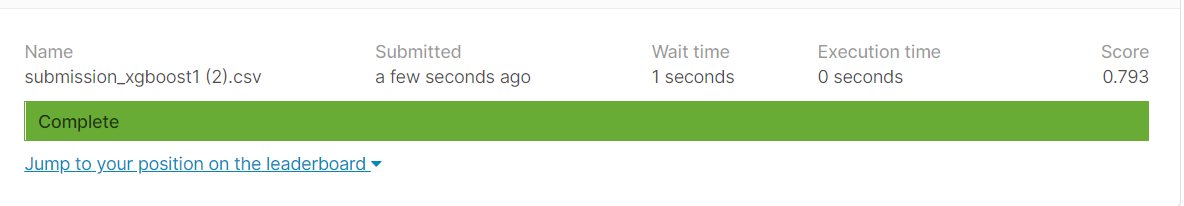

xgboost_test_auc = 0.793

**Stacking Classifier**

In [78]:
import six
import sys
sys.modules['sklearn.externals.six'] = six


In [114]:
from mlxtend.classifier import StackingClassifier

In [115]:
#classifier 1
knn_model = KNeighborsClassifier(algorithm ='kd_tree',n_neighbors = 45,weights='uniform')
knn_model.fit(X_train,y_train)

#Classifier 2
model = LogisticRegression(C= 0.1, penalty = 'l1', solver = 'liblinear',class_weight='balanced')
model.fit(X_train,y_train)

#Classifier 3
svc_clf = SVC(C=0.0001, kernel='sigmoid', probability=True)
svc_clf.fit(X_train,y_train)

#classifier 3

rdf_clf = RandomForestClassifier(max_depth=2, n_estimators=400,class_weight='balanced')
rdf_clf.fit(X_train,y_train)
#classifier 4

tree_clf = DecisionTreeClassifier(max_depth = 3,class_weight='balanced')
tree_clf.fit(X_train,y_train)

#classifier 5
xg_clf = XGBClassifier(max_depth=2, n_estimators=500, scale_pos_weight=0.5)
xg_clf.fit(X_train,y_train)


#Stacking Classifer

sclf = StackingClassifier(classifiers=[knn_model,model,svc_clf,rdf_clf,tree_clf,xg_clf],meta_classifier=model,use_probas=True)

#fit the model
sclf.fit(X_train,y_train)

#predict in probabilities

y_pred = sclf.predict(X_train)


In [116]:
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

1.0


In [117]:
y_pred_stack_test = sclf.predict_proba(X_test)[:,1]

In [118]:
y_pred_stack_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_stack_test})


y_pred_stack_test.to_csv('submission_stack_file.csv', index=False)  
y_pred_stack_test.head(20)

,ID,Target
0,250,0.723233
1,251,0.652485
2,252,0.638395
3,253,0.921526
4,254,0.891676
5,255,0.465294
6,256,0.309231
7,257,0.139382
8,258,0.919522
9,259,0.330495


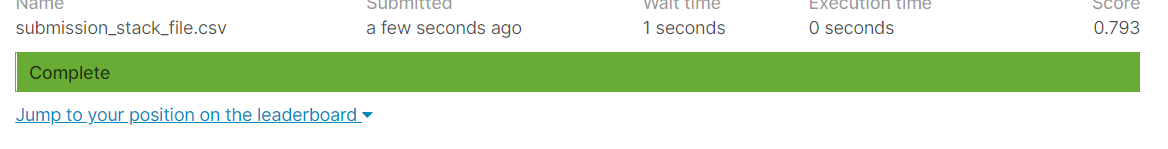

Test_auc = 0.79

### Summary of All Models

In [2]:
from texttable import Texttable
t = Texttable()
t.add_rows([['Model','Hyper-parameter','Train AUC','Test AUC'],['Knn_Model',r"{'algorithm': 'kd_tree', 'n_neighbors': 45}",0.55,0.66],
           ['logistic Regresstion',r"{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}",0.90,0.844],['Support Vector Machine',
           r"{'C': 0.001, 'kernel': 'sigmoid'}",0.52,0.72],['XGBoost Classifier',r"{'max_depth': 2, 'n_estimators': 500}",1.00,0.79],
            ['Random forest',r"{'max_depth': 2, 'n_estimators': 400}",0.52,0.74], ['DecisionTree',r"{'max_depth': 3}",0.79,0.58],
            ['Calibrated Model',"--",1.00,0.79]])

print(t.draw())

+------------------------+------------------------------+-----------+----------+
|         Model          |       Hyper-parameter        | Train AUC | Test AUC |
+========================+==============================+===========+==========+
| Knn_Model              | {'algorithm': 'kd_tree',     | 0.550     | 0.660    |
|                        | 'n_neighbors': 45}           |           |          |
+------------------------+------------------------------+-----------+----------+
| logistic Regresstion   | {'C': 0.1, 'penalty': 'l1',  | 0.900     | 0.844    |
|                        | 'solver': 'liblinear'}       |           |          |
+------------------------+------------------------------+-----------+----------+
| Support Vector Machine | {'C': 0.001, 'kernel':       | 0.520     | 0.720    |
|                        | 'sigmoid'}                   |           |          |
+------------------------+------------------------------+-----------+----------+
| XGBoost Classifier     | {

### Observation

1.We have read the training and test dataset. After reading both of dataset, we got it know that test dataset is having more features compare to training dataset.
2. Dropped the labled data from both train and test datasets.
4. Used GridSerach Validation for hyper-parameter tuning.
5. We have applied following machine learning algorithm:
   1.KNN : The KNN algorithm trained the model with parameter(algorithm = 'kd_tree', and n_neighbors=45) and gave train_AUC=0.55    and Test Auc = 0.66 . Model is less accurate but it is not overfitted.
   
   2.Logistic Regression : The Logistic regression algorithm trained the model with parameter(C=0.1,penalty=l1,solver=liblinear)    and gave train_AUC = 0.90 and Test_auc=0.844 which is working as expected.
   
   3.Support Vector Machine: The SVM algorithm trained the model with parameter(C=0.001,kernel=sigmoid) and got the  train_AUC=0.52 and Test_AUC = 0.72.Model is not overfitted
   
   4.XGBoost Classifier: The XGBoost classifier trained the model with parameter(max_depth=2,n_estimators=500) and got the train_AUC= 1.0 and Test_AUC=0.79.Model is accurate and not overfitted
   
   5.Random Forest : The Random Forest classifier trained the model with parameter(max_depth=2,n_estimators=400) and got the train_AUC = 0.52 and test_AUC = 0.74. Model is not overfitted
   
   6.DecisionTree : The Decision Tree classifier trained the model with parameter(max_depth=3) and got the train_AUC = 0.790 and test_AUC=0.580 .Model is overfitting. Decision Tree is poorly working.
   
   7.Calibrated model gave train_AUC = 1.0 and Test_AUC = 0.79. Model is accurate and not overfitted.
   
Logistic Regression is working well with Test AUC = 0.844 from above applied algorithm